Processing exponential distribution: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:17<00:00, 15.49s/it]


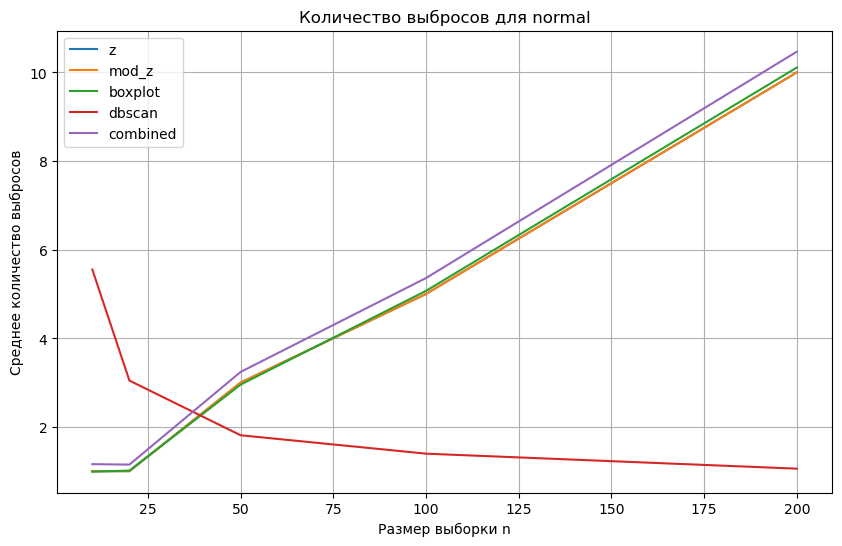

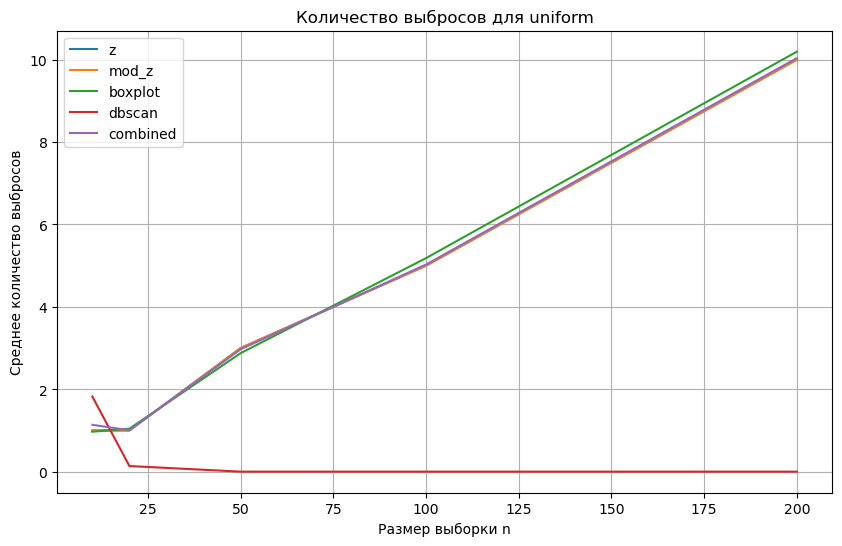

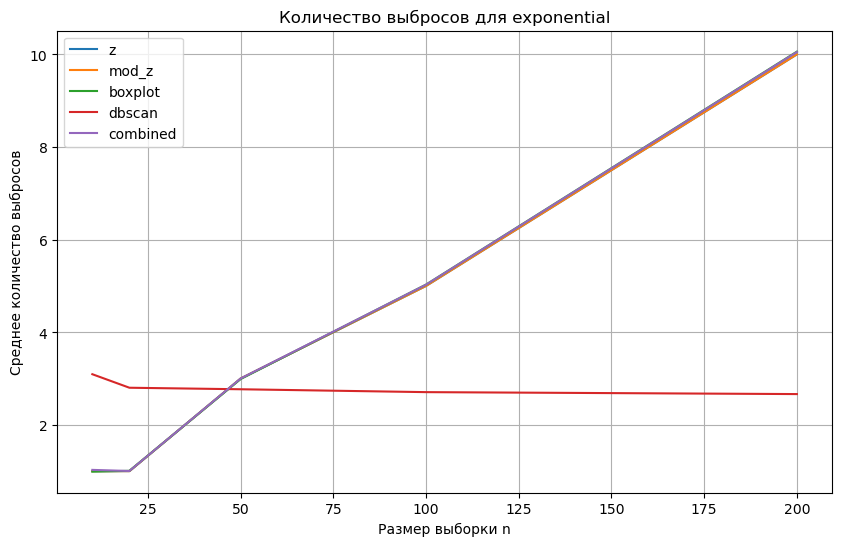

In [5]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from tqdm import tqdm

M = 1000  
n_values = [10, 20, 50, 100, 200]
alpha = 0.05

def generate_normal_dist(n):
    return np.random.normal(0, 1, n)

def generate_uniform_dist(n):
    return np.random.uniform(-1, 1, n)

def generate_exp_dist(n):
    return np.random.exponential(1, n) - 1

def z_score(dist):
    mean = np.mean(dist)
    std = np.std(dist, ddof=1)
    return (dist - mean) / std

def modified_z_score(dist):
    median = np.median(dist)
    mad = np.median(np.abs(dist - median))
    return 0.6745 * (dist - median) / mad if mad != 0 else np.zeros_like(dist)

def find_k(dist):
    q1, q3 = np.percentile(dist, [25, 75])
    iqr = q3 - q1

    k_values = np.linspace(0.1, 10, 1000)
    min_diff = float('inf')
    best_k = None

    for k in k_values:
        lower_bound = q1 - k * iqr
        upper_bound = q3 + k * iqr
        outliers = (dist < lower_bound) | (dist > upper_bound)
        outlier_fraction = np.mean(outliers)
        diff = np.abs(outlier_fraction - alpha)
        if diff < min_diff:
            min_diff = diff
            best_k = k
    return best_k

def boxplot_limits(dist, k):
    q1, q3 = np.percentile(dist, [25, 75])
    iqr = q3 - q1
    return q1 - k * iqr, q3 + k * iqr

def dbscan_outliers(dist, eps, min_samples):
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(dist.reshape(-1, 1))
    return np.sum(db.labels_ == -1)

results = {
    'normal': {n: {'z': [], 'mod_z': [], 'boxplot': [], 'dbscan': [], 'combined': []} for n in n_values},
    'uniform': {n: {'z': [], 'mod_z': [], 'boxplot': [], 'dbscan': [], 'combined': []} for n in n_values},
    'exponential': {n: {'z': [], 'mod_z': [], 'boxplot': [], 'dbscan': [], 'combined': []} for n in n_values},
}

distributions = {
    'normal': generate_normal_dist,
    'uniform': generate_uniform_dist,
    'exponential': generate_exp_dist,
}

for dist_name, generate_func in distributions.items():
    for n in tqdm(n_values, desc=f"Processing {dist_name} distribution"):
        for _ in range(M):
            dist = generate_func(n)
            
            z_scores = z_score(dist)
            mod_z_scores = modified_z_score(dist)
            k = find_k(dist)
            lower_limit, upper_limit = boxplot_limits(dist, k)
            
            z_crit = np.percentile(np.abs(z_scores), 100 * (1 - alpha))
            z_outliers = np.sum(np.abs(z_scores) > z_crit)
            
            mod_z_crit = np.percentile(np.abs(mod_z_scores), 100 * (1 - alpha))
            mod_z_outliers = np.sum(np.abs(mod_z_scores) > mod_z_crit)
            
            boxplot_outliers = np.sum((dist < lower_limit) | (dist > upper_limit))
            
            eps = 0.5
            min_samples = 5
            dbscan_outliers_count = dbscan_outliers(dist, eps, min_samples)
            
            combined_outliers = np.sum(
                ((np.abs(z_scores) > z_crit).astype(int) +
                 (np.abs(mod_z_scores) > mod_z_crit).astype(int) +
                 ((dist < lower_limit) | (dist > upper_limit)).astype(int) +
                 (dbscan_outliers(dist, eps, min_samples) > 0).astype(int)) >= 2
            )
            
            results[dist_name][n]['z'].append(z_outliers)
            results[dist_name][n]['mod_z'].append(mod_z_outliers)
            results[dist_name][n]['boxplot'].append(boxplot_outliers)
            results[dist_name][n]['dbscan'].append(dbscan_outliers_count)
            results[dist_name][n]['combined'].append(combined_outliers)

for dist_name in distributions.keys():
    plt.figure(figsize=(10, 6))
    for method in ['z', 'mod_z', 'boxplot', 'dbscan', 'combined']:
        mean_outliers = [np.mean(results[dist_name][n][method]) for n in n_values]
        plt.plot(n_values, mean_outliers, label=method)
    
    plt.title(f"Количество выбросов для {dist_name}")
    plt.xlabel("Размер выборки n")
    plt.ylabel("Среднее количество выбросов")
    plt.legend()
    plt.grid()
    plt.show()
